In [1]:
!nvidia-smi

Wed May 28 08:37:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Data Source
[Kaggle Twitter Sentiment Dataset](https://https://www.kaggle.com/datasets/kazanova/sentiment140)

# Data Analysis

In [3]:
import numpy as np
import pandas as pd

In [4]:
df = pd.read_csv('drive/MyDrive/Data/tweets.csv',names=['label','id','date','status','user','text'])

In [5]:
df.head()

,label,id,date,status,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
df = df[['text','label']]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1600000 non-null  object
 1   label   1600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [8]:
df['label'].value_counts()

,count
label,
0,800000
4,800000


In [9]:
df['label'] = df['label'].apply(lambda label: 'Positive' if label else 'Negative')

In [10]:
df.head()

,text,label
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Negative
1,is upset that he can't update his Facebook by ...,Negative
2,@Kenichan I dived many times for the ball. Man...,Negative
3,my whole body feels itchy and like its on fire,Negative
4,"@nationwideclass no, it's not behaving at all....",Negative


# Data Visualization

In [11]:
import seaborn as sns
sns.set_theme(rc={'figure.figsize':(10,5)})

<Axes: xlabel='label', ylabel='count'>

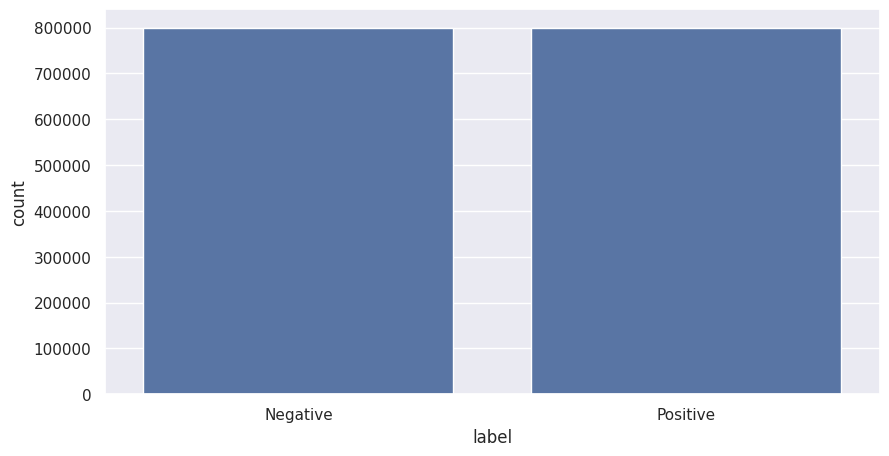

In [12]:
sns.countplot(x='label',data=df)

In [13]:
df['length'] = df['text'].apply(lambda text: len(text.split()))

<Axes: ylabel='length'>

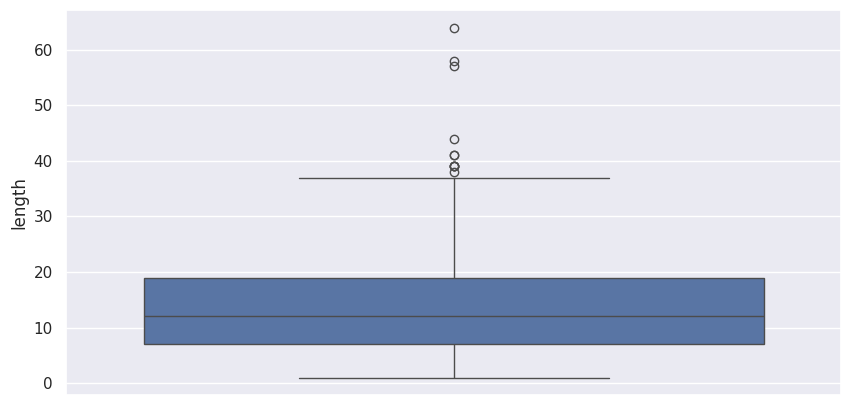

In [14]:
sns.boxplot(y='length',data=df)

<Axes: xlabel='length', ylabel='count'>

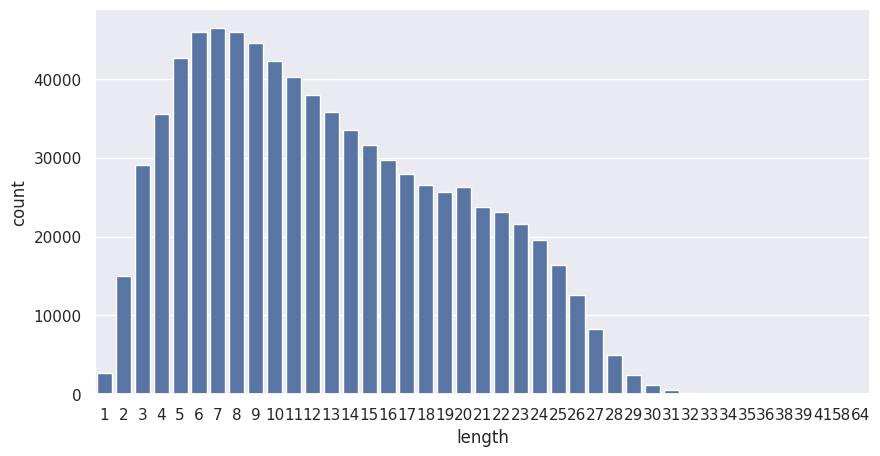

In [15]:
sns.countplot(x='length',data=df[df['label'] == 'Positive'])

<Axes: xlabel='length', ylabel='count'>

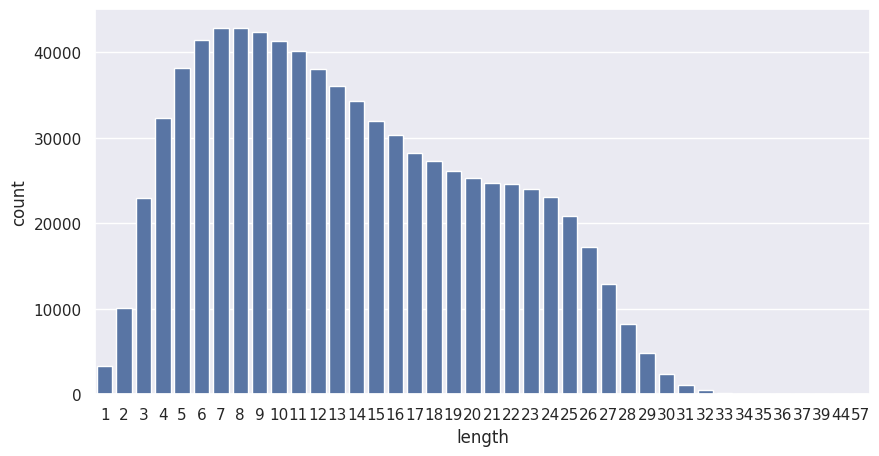

In [16]:
sns.countplot(x='length',data=df[df['label'] == 'Negative'])

In [17]:
df.drop('length',axis=1,inplace=True)

# Data Preprocessing

In [18]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

In [20]:
stopwords = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
noise = "https?://[^\s]+|@([A-Za-z0-9_]{1,15})|[^A-Za-z0-9]+"

In [21]:
def noisefree(text: str) -> str:
    alphanum = re.sub(noise,' ',str(text).lower())
    tokens = [stemmer.stem(word) for word in alphanum.split() if word not in stopwords]
    return ' '.join(tokens)

In [22]:
df['text'] = df['text'].apply(noisefree)

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
training_set, testing_set = train_test_split(df,test_size=0.01)

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])

In [27]:
X_train = tokenizer.texts_to_sequences(training_set['text'])
X_test = tokenizer.texts_to_sequences(testing_set['text'])

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [29]:
X_train = pad_sequences(X_train,maxlen=35)
X_test = pad_sequences(X_test,maxlen=35)

In [30]:
from sklearn.preprocessing import LabelEncoder

In [31]:
encoder = LabelEncoder()
encoder.fit(training_set['label'])

LabelEncoder()

In [32]:
y_train = encoder.transform(training_set['label'])
y_test = encoder.transform(testing_set['label'])

In [33]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [34]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1584000, 35) (16000, 35) (1584000, 1) (16000, 1)


# Word Embedding

In [35]:
from gensim.models import Word2Vec

In [36]:
corpus = df['text'].apply(lambda text: text.split())

In [37]:
embedding_model = Word2Vec(sentences=corpus,vector_size=100,window=10,min_count=1,workers=5)

In [38]:
vector = embedding_model.wv
embedding = [vector[word] if word in vector else [0]*100 for word in tokenizer.word_index]
embedding.insert(0,[0]*100)
embedding = np.array(embedding)

# Deep Learning

In [39]:
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, Conv1D, Bidirectional, LSTM, Dense, Dropout

In [40]:
input_layer = Input(shape=(35,),dtype='int32')

In [41]:
hidden_layer = Embedding(
    input_dim=len(embedding),
    output_dim=100,
    weights=[embedding],
    trainable=False
)(input_layer)

In [42]:
hidden_layer = SpatialDropout1D(rate=0.2)(hidden_layer)

In [43]:
hidden_layer = Conv1D(
    filters=256,
    kernel_size=5,
    activation='relu'
)(hidden_layer)

In [44]:
hidden_layer = Bidirectional(LSTM(
    units=256,
    dropout=0.2,
    recurrent_dropout=0.2
))(hidden_layer)

In [45]:
hidden_layer = Dense(units=1024,activation='relu')(hidden_layer)
hidden_layer = Dropout(rate=0.5)(hidden_layer)
hidden_layer = Dense(units=1024,activation='relu')(hidden_layer)
output_layer = Dense(units=1,activation='sigmoid')(hidden_layer)

In [46]:
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [47]:
model = Model(input_layer,output_layer)
model.compile(
    optimizer=Adam(learning_rate=10**-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [48]:
reduce = ReduceLROnPlateau(
    factor=0.1,
    min_lr=10**-5,
    monitor='val_loss',
    verbose=2
)

In [49]:
model.fit(
    x=X_train,
    y=y_train,
    batch_size=1024,
    epochs=20,
    validation_data=(X_test,y_test),
    callbacks=[reduce]
)

Epoch 1/20
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 371s 232ms/step - accuracy: 0.7248 - loss: 0.5327 - val_accuracy: 0.7713 - val_loss: 0.4702 - learning_rate: 0.0010
Epoch 2/20
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 374s 231ms/step - accuracy: 0.7696 - loss: 0.4755 - val_accuracy: 0.7794 - val_loss: 0.4587 - learning_rate: 0.0010
Epoch 3/20
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 389s 235ms/step - accuracy: 0.7766 - loss: 0.4638 - val_accuracy: 0.7829 - val_loss: 0.4526 - learning_rate: 0.0010
Epoch 4/20
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 374s 230ms/step - accuracy: 0.7815 - loss: 0.4557 - val_accuracy: 0.7867 - val_loss: 0.4471 - learning_rate: 0.0010
Epoch 5/20
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 381s 229ms/step - accuracy: 0.7849 - loss: 0.4501 - val_accuracy: 0.7883 - val_loss: 0.4449 - learning_rate: 0.0010
Epoch 6/20
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 387s 232ms/step - accuracy: 0.7879 - loss: 0.4453 - val_accuracy: 0.7881 - val_loss: 0.4442 - learning_rate: 0.0010
Epoch 7/20
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 377s 229ms

# Performance

In [50]:
from sklearn.metrics import classification_report

In [51]:
predictions = model.predict(X_test)

500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step


In [53]:
predictions = predictions.reshape(-1) >= 0.5
y_test = y_test.reshape(-1)

In [54]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      7969
           1       0.80      0.78      0.79      8031

    accuracy                           0.79     16000
   macro avg       0.79      0.79      0.79     16000
weighted avg       0.79      0.79      0.79     16000



In [55]:
model.save('drive/MyDrive/Data/sentiment.keras')

In [56]:
import json

tokenizer_json = tokenizer.to_json()
with open('drive/MyDrive/Data/sentiment_tokenizer.json', 'w') as f:
    json.dump(tokenizer_json, f)